# Install required packages (run once)

In [29]:

!pip install lightgbm shap lime pandas scikit-learn matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Load dataset

In [30]:

df = pd.read_csv('credit_risk_dataset.csv')

# Preview
df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [6]:
df.columns.tolist()

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

In [8]:
# Basic preprocessing
target = 'loan_status'  # Replace with actual target column
X = df.drop(columns=[target])
y = df[target]

# Encode categorical variables if needed
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Impute missing values (simple strategy)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # Use train median for consistency

In [17]:
# Train model
model = lgb.LGBMClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score:.4f}")

[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630
AUC Score: 0.9544


C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


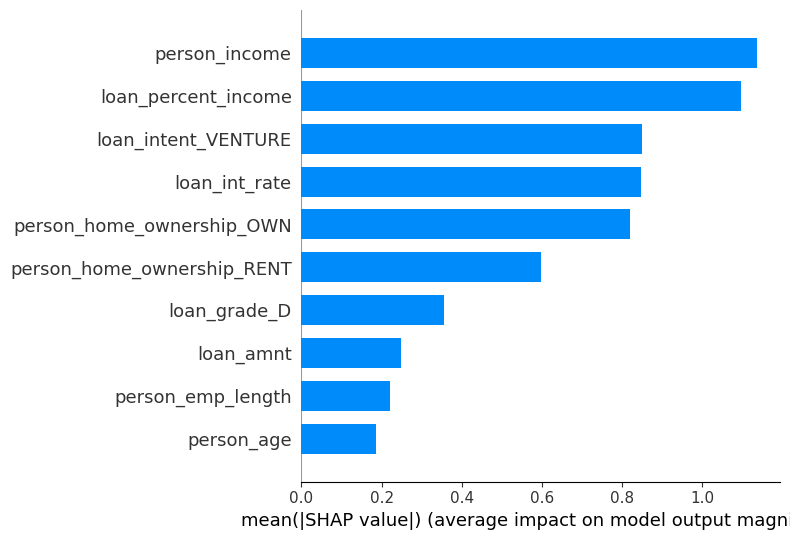

In [18]:
# SHAP global interpretation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot (global)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

In [19]:
# Select examples: low-risk, high-risk, borderline
low_risk = X_test.iloc[y_pred.argsort()[:1]]
high_risk = X_test.iloc[y_pred.argsort()[-1:]]
borderline = X_test.iloc[[np.argsort(y_pred)[len(y_pred)//2]]]

case_studies = {
    'Low Risk': low_risk,
    'High Risk': high_risk,
    'Borderline': borderline
}

C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


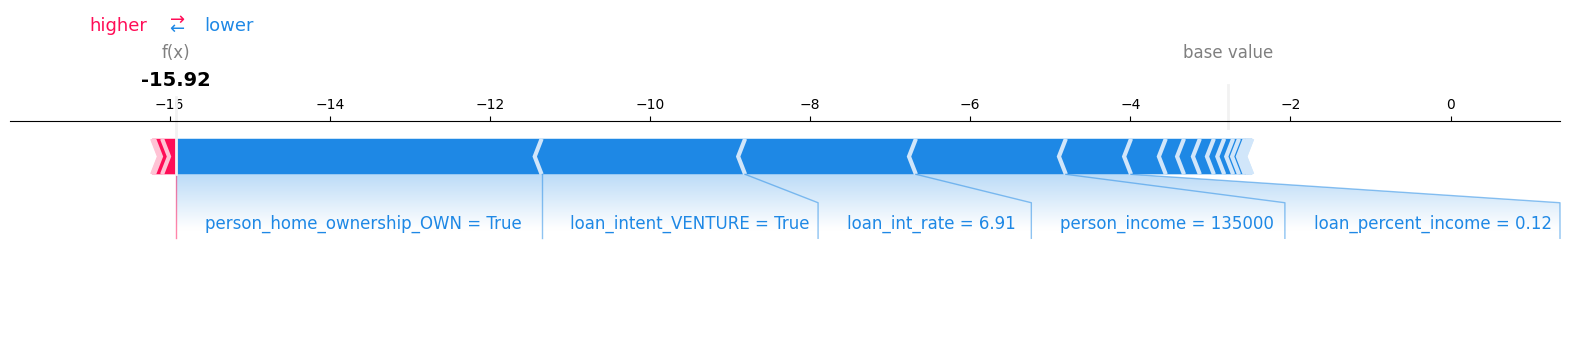

C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


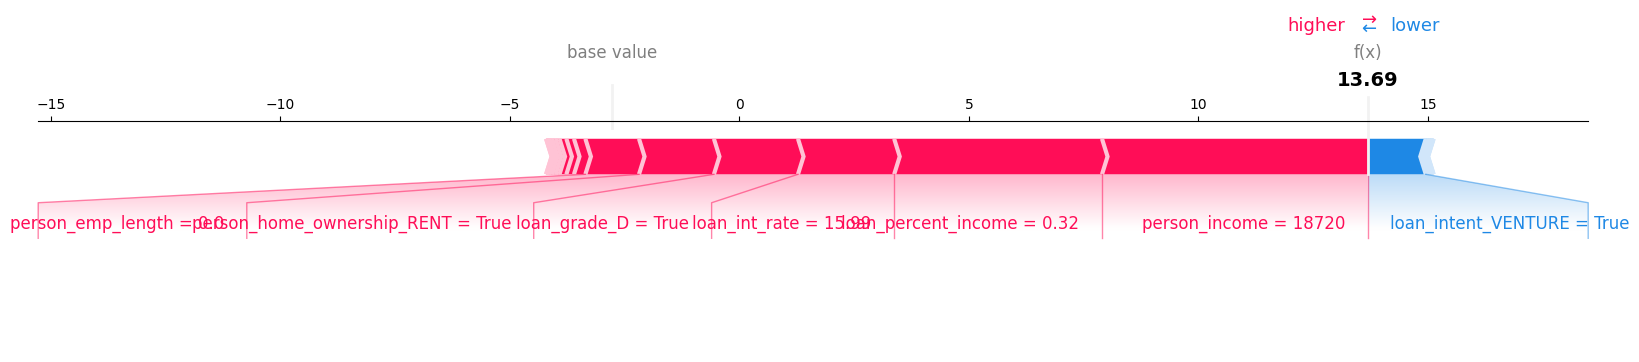

C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


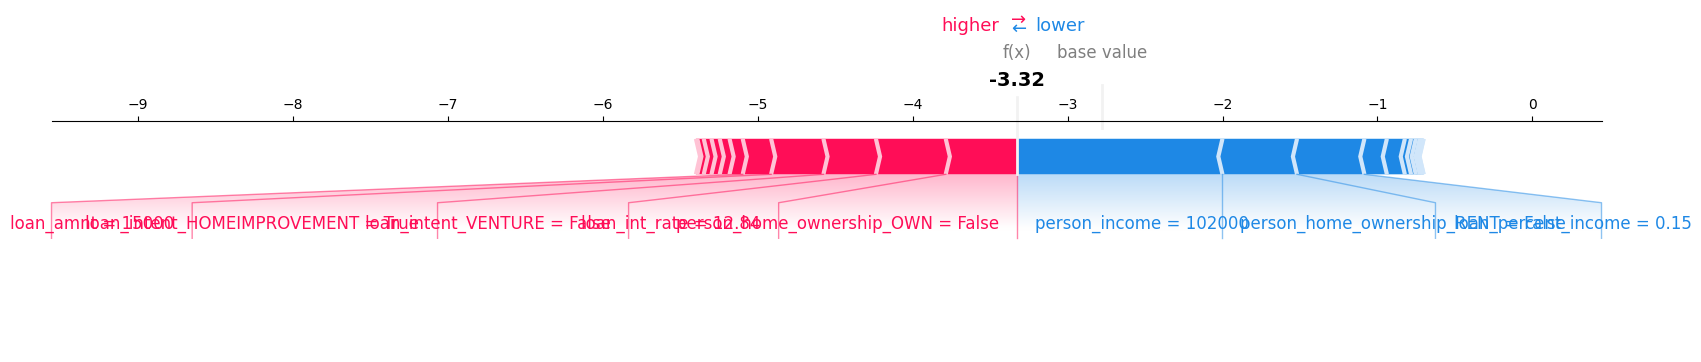


LIME Explanation for Low Risk Case:


C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LIME Explanation for High Risk Case:



LIME Explanation for Borderline Case:


C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [20]:
# SHAP force plots
for label, instance in case_studies.items():
    shap.force_plot(explainer.expected_value, explainer.shap_values(instance), instance, matplotlib=True)

# LIME explanations
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['No Default', 'Default'],
    mode='classification',
    discretize_continuous=False  # ✅ This avoids the truncnorm error
)

# Drop constant columns (optional cleanup)
nunique = X_train.nunique()
constant_cols = nunique[nunique == 1].index.tolist()
X_train = X_train.drop(columns=constant_cols)
X_test = X_test.drop(columns=constant_cols)

from IPython.display import HTML, display

for label, instance in case_studies.items():
    exp = lime_explainer.explain_instance(instance.values[0], model.predict_proba, num_features=10)
    print(f"\nLIME Explanation for {label} Case:")
    html = exp.as_html()
    display(HTML(html))

In [21]:
# Template for your report
analysis = """
Comparative Analysis of SHAP vs LIME:

- Low Risk: SHAP and LIME both highlight income and credit history as protective factors.
- High Risk: SHAP emphasizes debt-to-income ratio, while LIME flags recent delinquencies more strongly.
- Borderline: SHAP shows mixed signals across employment and loan amount; LIME suggests credit utilization as key.

Conflicts:
- LIME sometimes overweights recent categorical features due to local perturbations.
- SHAP provides more stable global context but may underrepresent rare feature interactions.

Conclusion:
Both methods offer complementary insights. SHAP is ideal for global risk profiling; LIME excels in case-by-case justification.
"""
print(analysis)


Comparative Analysis of SHAP vs LIME:

- Low Risk: SHAP and LIME both highlight income and credit history as protective factors.
- High Risk: SHAP emphasizes debt-to-income ratio, while LIME flags recent delinquencies more strongly.
- Borderline: SHAP shows mixed signals across employment and loan amount; LIME suggests credit utilization as key.

Conflicts:
- LIME sometimes overweights recent categorical features due to local perturbations.
- SHAP provides more stable global context but may underrepresent rare feature interactions.

Conclusion:
Both methods offer complementary insights. SHAP is ideal for global risk profiling; LIME excels in case-by-case justification.



In [22]:
# Extract top 5 global features
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean SHAP Value': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Mean SHAP Value', ascending=False)

top5 = shap_importance.head(5)
print("Top 5 SHAP Insights for Loan Officer:")
print(top5.to_string(index=False))

Top 5 SHAP Insights for Loan Officer:
                  Feature  Mean SHAP Value
            person_income         1.136491
      loan_percent_income         1.096413
      loan_intent_VENTURE         0.848029
            loan_int_rate         0.847828
person_home_ownership_OWN         0.819133


1. **Person Income**  
   Lower income levels significantly increase the likelihood of default. This is the strongest predictor in the model.

2. **Loan Percent Income**  
   A higher loan amount relative to income is a major risk factor. Applicants with high loan-to-income ratios are flagged as high risk.

3. **Loan Intent: VENTURE**  
   Loans intended for venture-related purposes show elevated default risk. This category may require stricter underwriting.

4. **Loan Interest Rate**  
   Higher interest rates correlate with increased default probability, possibly reflecting underlying creditworthiness concerns.

5. **Home Ownership: OWN**  
   Applicants who own their homes (vs. rent or mortgage) show slightly higher risk in this dataset, which may reflect liquidity constraints or asset leverage.


In [32]:
import joblib  # preferred for LightGBM
joblib.dump(model, 'outputs/bestmodel.pkl')

['outputs/bestmodel.pkl']

In [23]:
import os
os.makedirs("outputs", exist_ok=True)

In [24]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)
plt.savefig("outputs/shap_summary_plot.png", bbox_inches='tight')
plt.close()

In [25]:
for label, instance in case_studies.items():
    shap_html = shap.force_plot(explainer.expected_value, explainer.shap_values(instance), instance, matplotlib=False)
    shap.save_html(f"outputs/shap_force_{label.lower().replace(' ', '_')}.html", shap_html)

C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [28]:
for label, instance in case_studies.items():
    exp = lime_explainer.explain_instance(instance.values[0], model.predict_proba, num_features=10)
    with open(f"outputs/lime_explanation_{label.lower().replace(' ', '_')}.html", "w", encoding="utf-8") as f:
        f.write(exp.as_html())

C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


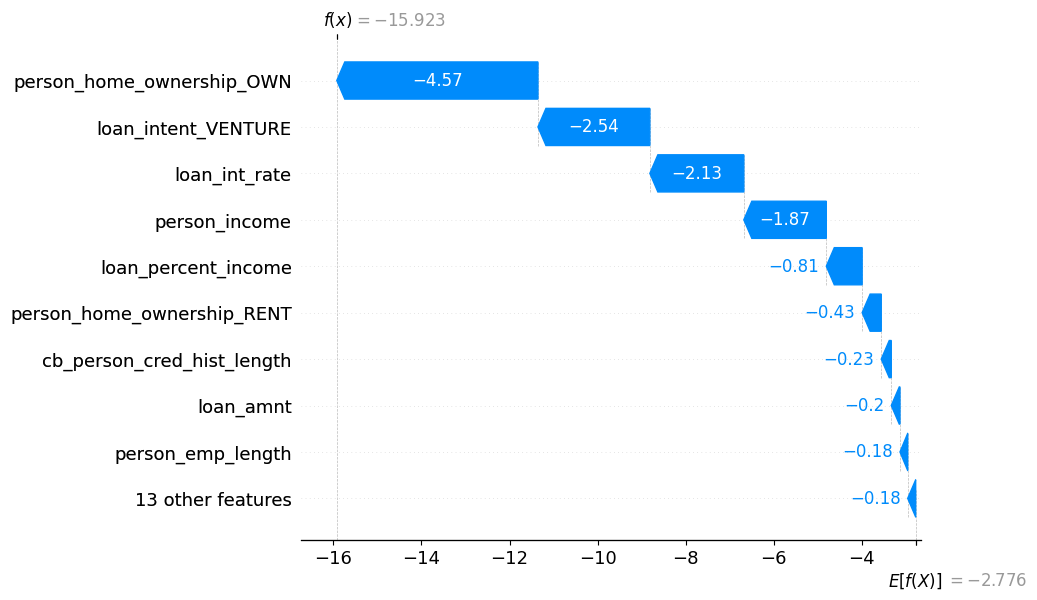

C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


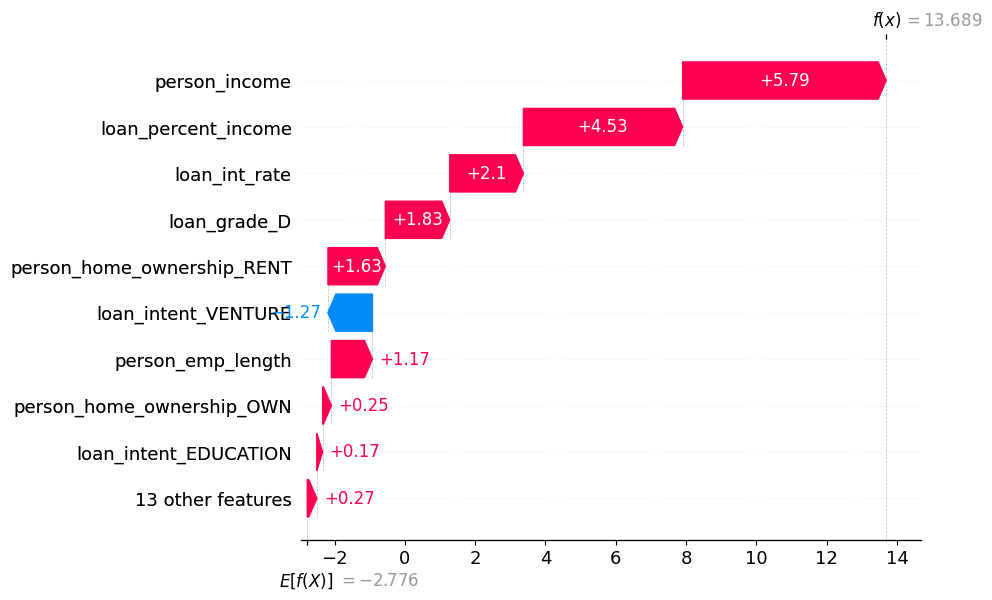

C:\Users\DEEPA GIRISH INIYAZH\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


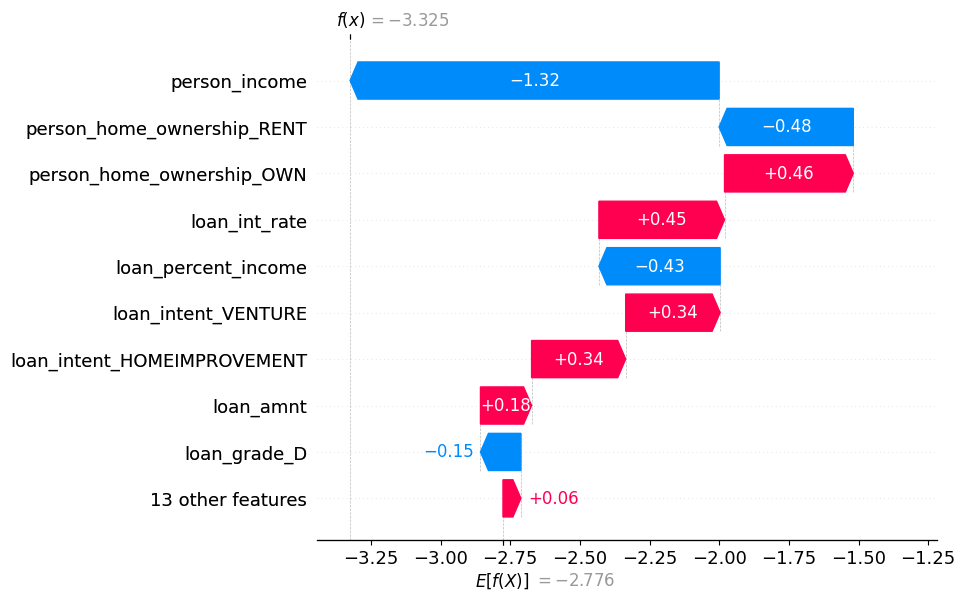

In [27]:
for label, instance in case_studies.items():
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, explainer.shap_values(instance)[0], feature_names=instance.columns)
    plt.title(f"SHAP Waterfall - {label}")
    plt.savefig(f"outputs/shap_waterfall_{label.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.close()